In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [70]:
df = pd.read_csv("../data/silver/master_table.csv")
df.fecha_efectiva = pd.to_datetime(df.fecha_efectiva, format="%Y-%m-%d", errors="coerce")
df.head()

,Id_cliente,fecha_efectiva,Id_tx,clase,valor
0,136,2021-03-03,6869,COMPRA,3495240.00
1,116,2020-11-29,4355,COMPRA,475800.00
2,116,2020-11-29,4355,COMPRA,350503.62
3,119,2020-09-29,5416,COMPRA,115775.00
4,121,2021-02-22,3249,COMPRA,1579898.00


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Id_cliente      3300 non-null   int64         
 1   fecha_efectiva  3300 non-null   datetime64[ns]
 2   Id_tx           3300 non-null   int64         
 3   clase           3277 non-null   object        
 4   valor           3282 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 129.0+ KB


# Dataviz - Graficos y analisis visuales

Para este punto se propone reañizar un analisis de distribucion de valor (montos de transaccion) en funcion de la demas informacion para identificar patrones interesantes. Se propone un analisis preliminar a nivel univariado, luego bivariado y en funcion de lo que se descubra escoger tecnicas aplicables al dataset.

El ultimo paso importante seria un analisis por cliente, util para esocger una tecnica que permita realizar una asignacion.Para este paso se podria intentar identificar algun tipo de cluster con algun modelo, dependiendo de este resultado, se usaurian reglas de negocios o los cluster prpopuestos en caso de tener algun tipo de sentido los cluster propuestos.

## NOTA IMPORTANTE

Los graficos fueron promts directos a chat GPT por temas de agilidad. Perder tiempo en alinear, escoger tema,tildes y seleccionar graficos de groupby no tiene mucho sentido. 

## Univariado

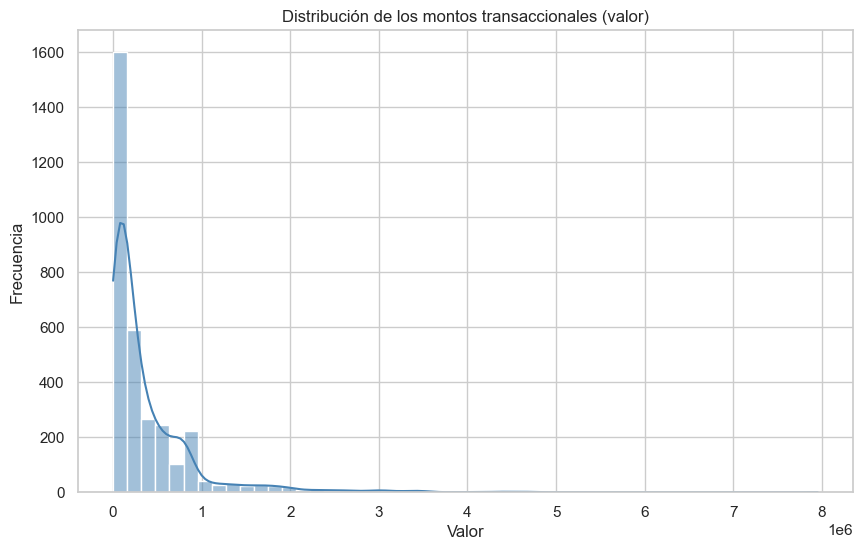

In [72]:
sns.histplot(df["valor"], kde=True, bins=50, color='steelblue')
plt.title("Distribución de los montos transaccionales (valor)")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.show()

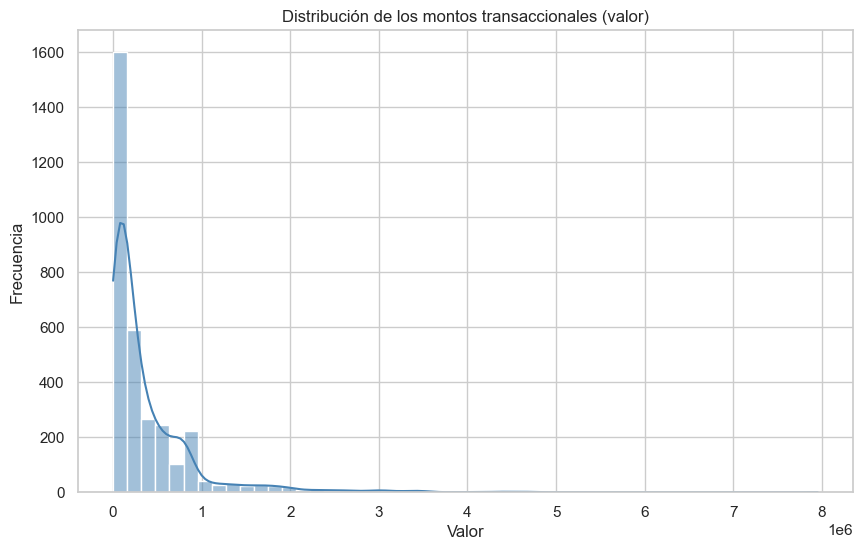

C:\Users\JhonatanSmithGarcía\AppData\Local\Temp\ipykernel_38484\2451981852.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="clase", palette="pastel", order=df["clase"].value_counts().index)


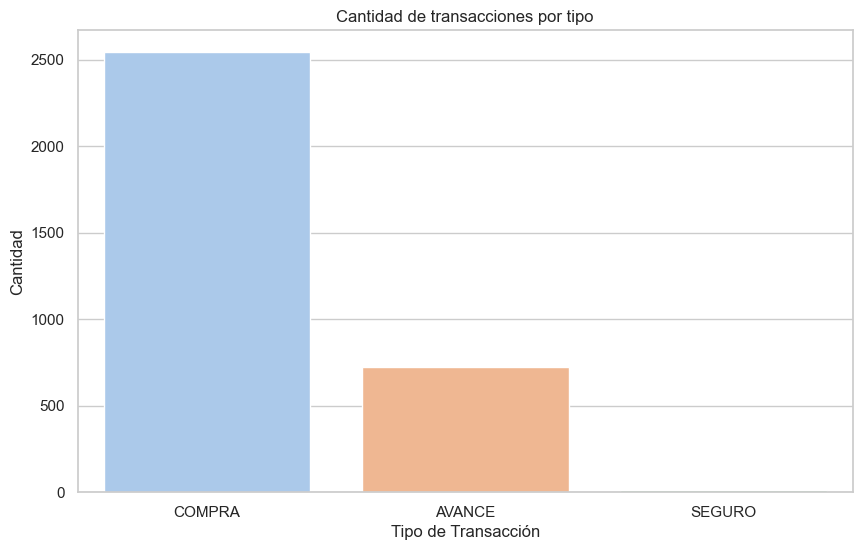

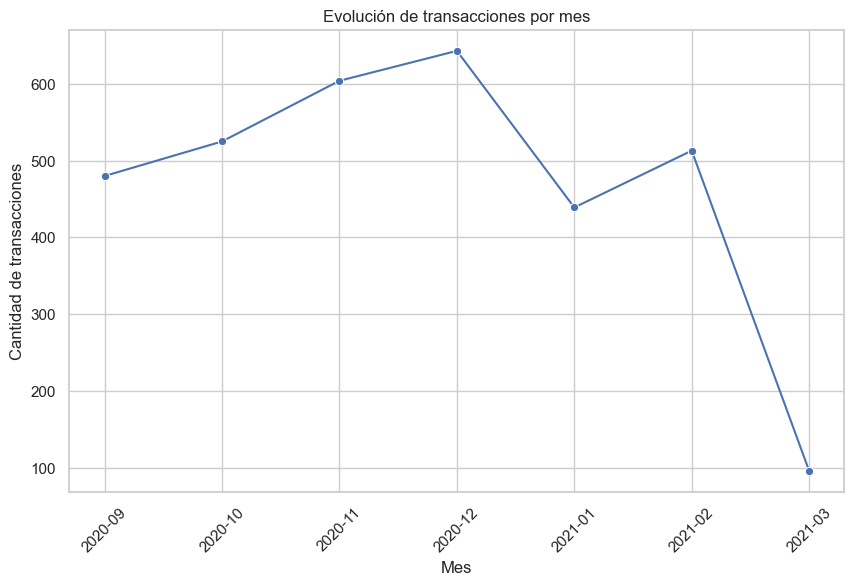

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo visual
sns.set(style="whitegrid")

# Tamaño general de los graficos
plt.rcParams["figure.figsize"] = (10, 6)

# ----------------------------------------
# 1. Distribución del monto transaccional
# ----------------------------------------
sns.histplot(df["valor"], kde=True, bins=50, color='steelblue')
plt.title("Distribución de los montos transaccionales (valor)")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.show()

# ----------------------------------------
# 2. Conteo de transacciones por tipo (clase)
# ----------------------------------------
sns.countplot(data=df, x="clase", palette="pastel", order=df["clase"].value_counts().index)
plt.title("Cantidad de transacciones por tipo")
plt.xlabel("Tipo de Transacción")
plt.ylabel("Cantidad")
plt.show()

# ----------------------------------------
# 3. Distribución temporal de las transacciones
# ----------------------------------------
df["mes"] = df["fecha_efectiva"].dt.to_period("M").astype(str)
tx_por_mes = df["mes"].value_counts().sort_index()

sns.lineplot(x=tx_por_mes.index, y=tx_por_mes.values, marker="o")
plt.title("Evolución de transacciones por mes")
plt.xlabel("Mes")
plt.ylabel("Cantidad de transacciones")
plt.xticks(rotation=45)
plt.show()


`Inisght`
 1. Distribucion altamente sesgada con cola pesada a la derecha, hay algunos datos que osbrepasan los 2 millones
 2. Muchos consumos pequeños, pocos grandes
 3. Se propone escala logaritmica para el valor de la transacion y ver mejor la info
 4. Seguros son practicamente descartables  (11) del total del dataset (menos del 0.3 %)
 5. Diciembre parece ser un mes clave para el comortamiento de las transaciones por mes. Al final hay una caida fuerte en las transcciones del dataset. Probablmente el trafico disminuye por estas fechas (hipotesis) o simplemente el dataset esta incompleto. 

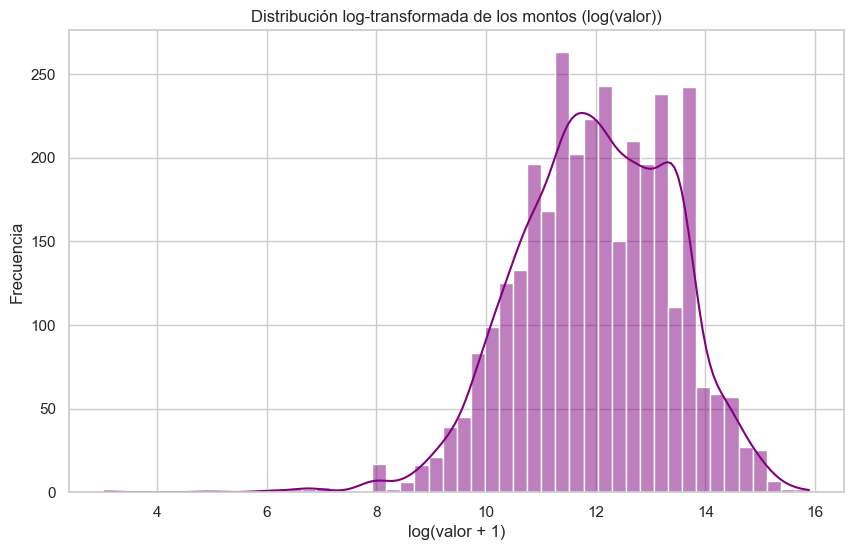

C:\Users\JhonatanSmithGarcía\AppData\Local\Temp\ipykernel_38484\1013597831.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="clase", y="valor", palette="pastel", showfliers=False)


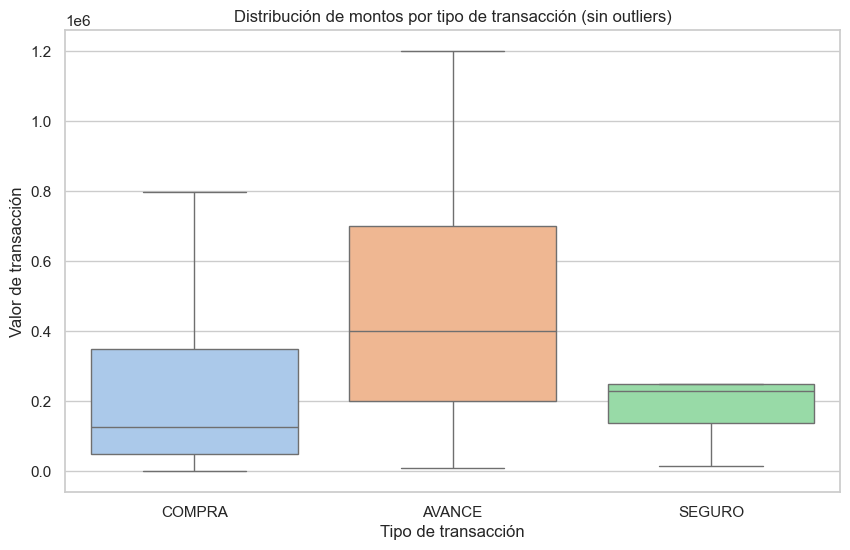

In [74]:
# Log-transformación (agregando 1 para evitar log(0))
df["log_valor"] = np.log1p(df["valor"])

# -------------------------
# 1. Histograma de log(valor)
# -------------------------
sns.histplot(df["log_valor"], bins=50, kde=True, color="purple")
plt.title("Distribución log-transformada de los montos (log(valor))")
plt.xlabel("log(valor + 1)")
plt.ylabel("Frecuencia")
plt.show()

# -------------------------
# 2. Boxplot del valor por clase
# -------------------------
sns.boxplot(data=df, x="clase", y="valor", palette="pastel", showfliers=False)
plt.title("Distribución de montos por tipo de transacción (sin outliers)")
plt.ylabel("Valor de transacción")
plt.xlabel("Tipo de transacción")
plt.show()


`Insight`
1. El log(valor) deja entrever una distribucion mas normal en los datos. Ideal para un ejercicio de modelacion, por ejemplo.
2. Avances suele tener un mayor rango de valoers (gasta 1.2 mill) y una media mas alta. **Los avances hacen que se retire mas dinero**
3. Seguros son relativamente planos, con bajo volumen y bajo rango → probablemente irrelevantes para modelado. **Mirar si esto se mete en el analisis o se hace parte del ejercicio de clustering**

**TO REMEMBER** Interesa clioentes con:
 1. Baja actividad - mayor descuento
 2. Afiniddad por avances pero no compras = mayor descuento
 3. Afinidad alta al prpoducto = No descuentos

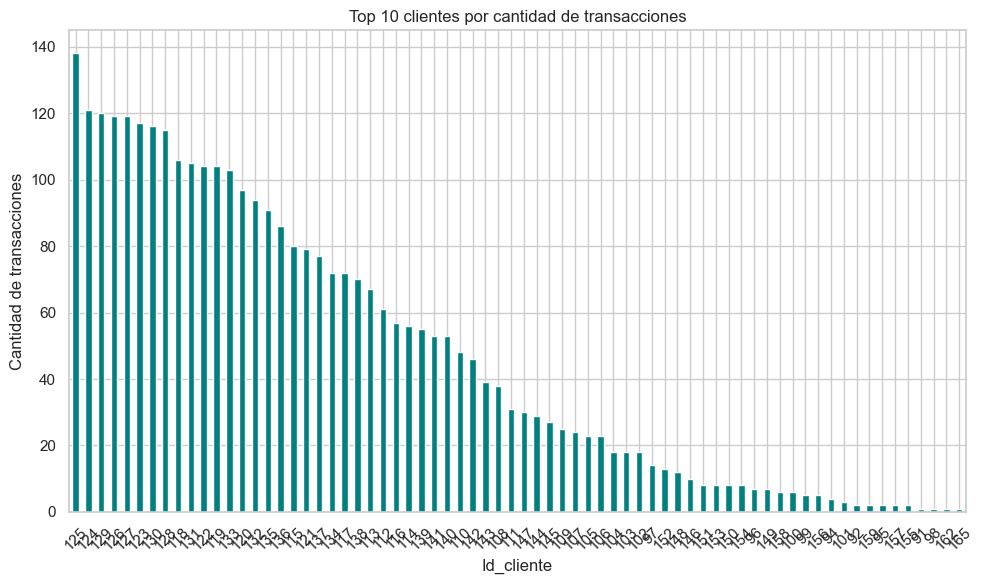

In [75]:
# Conteo total de transacciones por cliente
tx_por_cliente = df.groupby("Id_cliente")["valor"].count().sort_values(ascending=False).head(100)

tx_por_cliente.plot(kind="bar", color="teal")
plt.title("Top 10 clientes por cantidad de transacciones")
plt.xlabel("Id_cliente")
plt.ylabel("Cantidad de transacciones")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


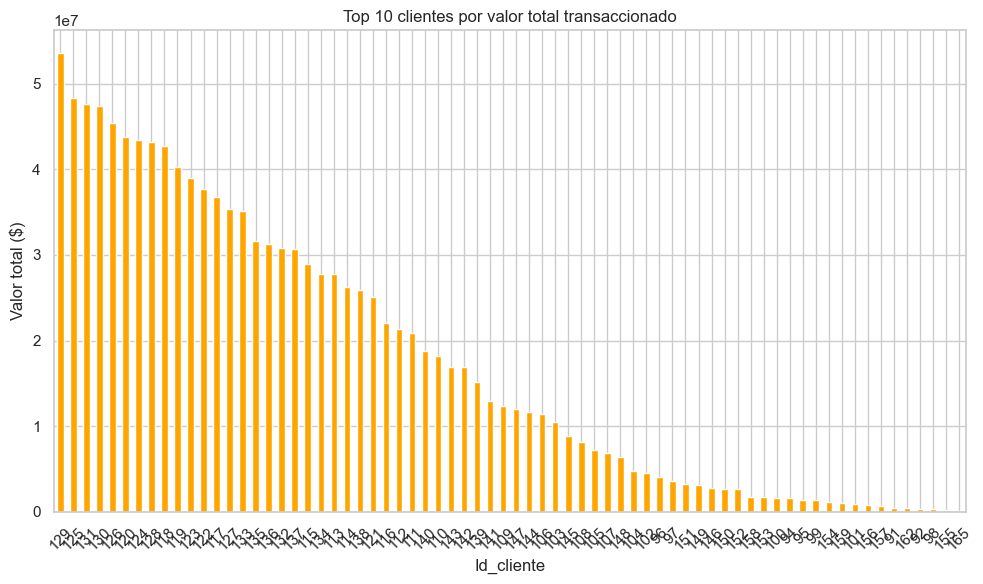

In [76]:
# Suma total de transacciones por cliente
valor_por_cliente = df.groupby("Id_cliente")["valor"].sum().sort_values(ascending=False).head(100)

valor_por_cliente.plot(kind="bar", color="orange")
plt.title("Top 10 clientes por valor total transaccionado")
plt.xlabel("Id_cliente")
plt.ylabel("Valor total ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


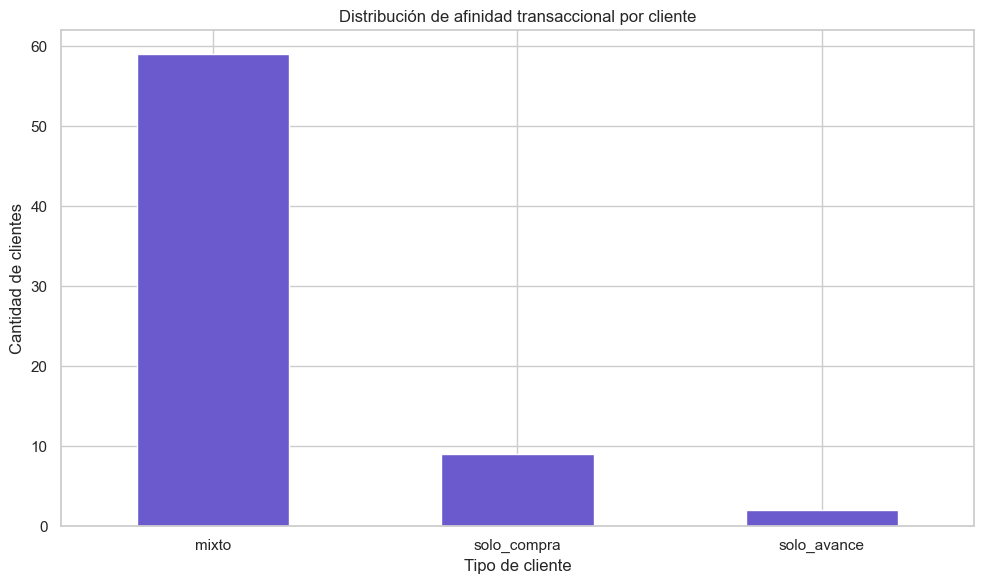

In [59]:
# Pivot para obtener suma por clase
tabla_afiliacion = df.pivot_table(index="Id_cliente", columns="clase", values="valor", aggfunc="sum", fill_value=0)

# Clasificación simple
def clasificar_cliente(row):
    if row["COMPRA"] > 0 and row["AVANCE"] == 0:
        return "solo_compra"
    elif row["AVANCE"] > 0 and row["COMPRA"] == 0:
        return "solo_avance"
    elif row["AVANCE"] > 0 and row["COMPRA"] > 0:
        return "mixto"
    else:
        return "sin_movimiento"

tabla_afiliacion["afinidad"] = tabla_afiliacion.apply(clasificar_cliente, axis=1)

# Conteo de tipos de afinidad
tabla_afiliacion["afinidad"].value_counts().plot(kind="bar", color="slateblue")
plt.title("Distribución de afinidad transaccional por cliente")
plt.xlabel("Tipo de cliente")
plt.ylabel("Cantidad de clientes")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


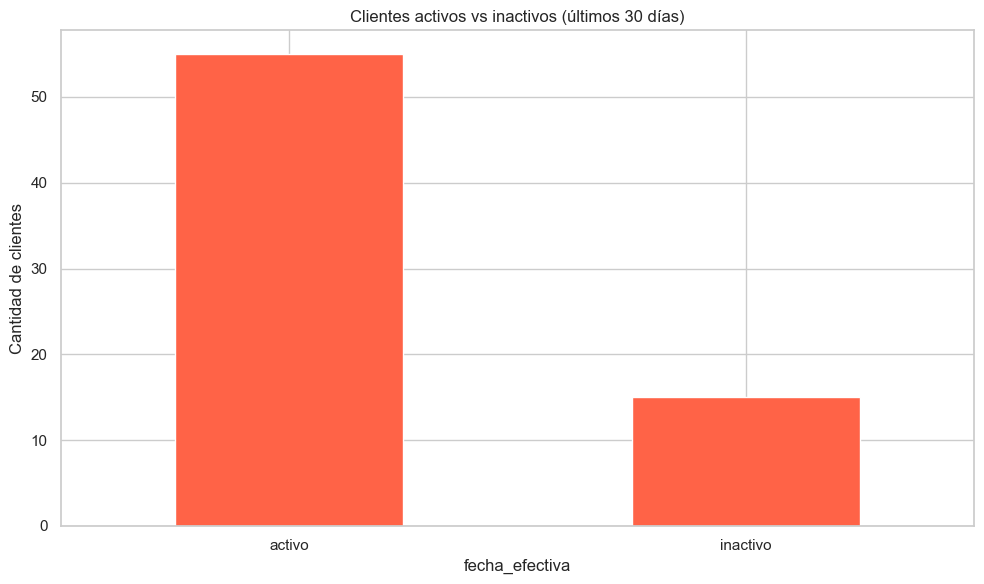

In [60]:
# Última transacción
ult_tx = df.groupby("Id_cliente")["fecha_efectiva"].max()
dias_inactivos = (df["fecha_efectiva"].max() - ult_tx).dt.days

# Clasificación
actividad = dias_inactivos.apply(lambda x: "activo" if x <= 30 else "inactivo")
actividad.value_counts().plot(kind="bar", color="tomato")
plt.title("Clientes activos vs inactivos (últimos 30 días)")
plt.ylabel("Cantidad de clientes")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


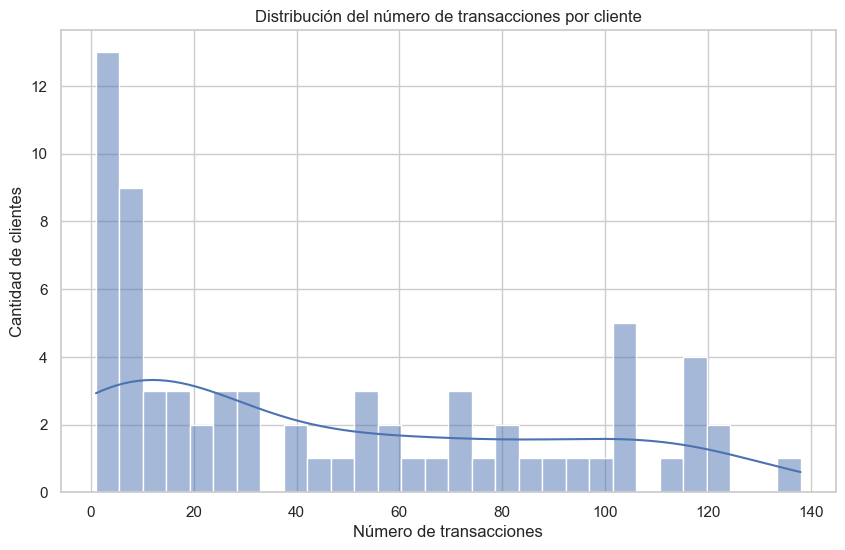

In [61]:
conteo_tx = df.groupby("Id_cliente")["valor"].count()
sns.histplot(conteo_tx, bins=30, kde=True)
plt.title("Distribución del número de transacciones por cliente")
plt.xlabel("Número de transacciones")
plt.ylabel("Cantidad de clientes")
plt.show()


`Insigths`

 1. Se ve claramente que hay algunos clientes que destacan. Vimos el top 10 (cuando vi el top 100 se pudo ver mejor la distribucion). El cliente 125 destaca por teneer mas activo en volumen
 2. Cleiten 129 tiene mas de 50 millones en transacciones
 3. Un porcetnajte alto de clientes mixtos (usan compra y avance) PERO **hay algunos que soo hacen compras o avances** que podria ser *el publico ideal para una estrategia*

# DataViz- Data to model

Con esto mehago una idea muy buena de la data y la forma que tiene. Ahora, quiero hacer un ejercicio para encontrar segmentos importantes en la informacion AKA un ejercicoi de clusters. 

**Agrupado vs desarupado:** El interes del ejercicio es reconocer un tipo de cliente particular, para esto se requiere una forma de comparar informacion de los clientes. El dataset per se tiene informacion relevante respecto a la transaccion de cada cliente pero si no se agrupa, estariamos haciendo un ejercico de ver "que transaciones son similares entre si" pero esto no es lo que me interesa, interesa es ver "que clientes son similares entre si", para esto se construyen una serie de metricas para cada clietne y se agrupan entre si para intentar identificar KPI o features que comnstraeten informacion entre clientes. 

In [62]:
df.clase.value_counts()

clase
COMPRA    2543
AVANCE     723
SEGURO      11
Name: count, dtype: int64

Esto podria ser problematico... Aunque per se no intento predcir clases pero tener data desbalñanceada no es buena :c

In [63]:
11/df.shape[0]*100 # Menos del 0.3% de una clase en el dataset. Casi que es depreciable la clase tipo "SEGURO". Esto no es significativo

0.33333333333333337

In [64]:
resumen = df.groupby(["Id_cliente", "clase"]).agg( # empieza agrupando por cliente y tipo de transaccion
    num_transacciones=("valor", "count"), # num de transacciones por clase y cliente
    total_valor=("valor", "sum"), # suma del valor gastado en esa clase
    promedio_valor=("valor", "mean"), # valor promedio gastado por cliente ene sa clase
    ultima_tx=("fecha_efectiva", "max") # ultima fecha ed la uktrima transaccion del cliente
).reset_index() # obviamente para vovlera  tener algo que tenga sentido para este nuvo df
pivot_resumen = resumen.pivot(index="Id_cliente", columns="clase", values="total_valor").fillna(0) # Los NA no me interesan puesto que pueden ser resultaod de un calculo numerico manual asi que, pos adios
pivot_resumen.drop(columns=["SEGURO"], inplace=True)  # Eliminamos la clase "SEGURO" por ser poco significativa, ñluego se analizan

pivot_resumen["ratio_avance_compra"] = pivot_resumen.get("AVANCE", 0) / (pivot_resumen.get("COMPRA", 1))

**Como llegamos a estos KPIs??** Una mezcla de experiencia, recomendacion de la prueba y profundas conversaciones con Chat GPT. Esto lo hago escencialmente con la idea de escoger preciamente variables numericas que permitan implementar analisis a mi comparativa entre clientes. Esto surge de pensar sobre la pregunta de ¿que pueden tener diferentes mis clientes entre si?. Obviamente teniendo en cuenta la mucha/poca informacion que se tiene. 

In [65]:
# Última fecha de transacción por cliente
ultima_fecha = df.groupby("Id_cliente")["fecha_efectiva"].max()
dias_inactivo = (df["fecha_efectiva"].max() - ultima_fecha).dt.days
pivot_resumen["dias_desde_ultima_tx"] = dias_inactivo
pivot_resumen["dias_desde_ultima_tx"].describe()

count     70.000000
mean      23.714286
std       35.786056
min        0.000000
25%        3.000000
50%        7.500000
75%       28.000000
max      183.000000
Name: dias_desde_ultima_tx, dtype: float64

<Axes: >

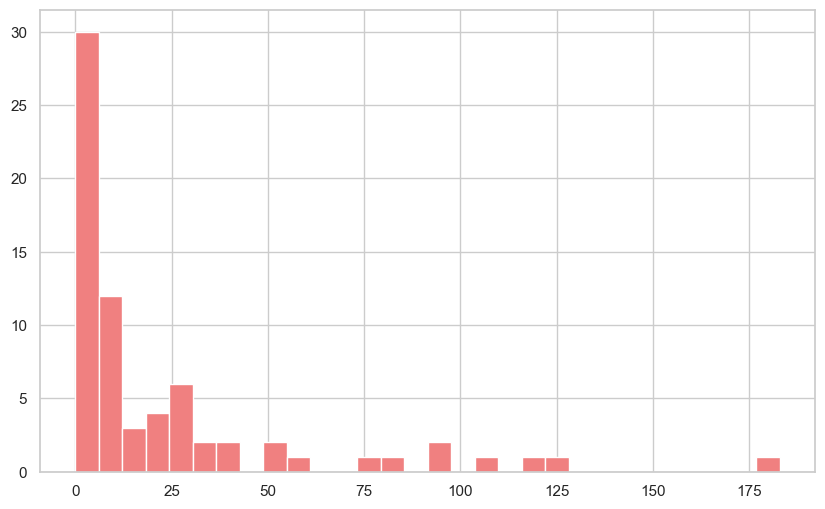

In [66]:
pivot_resumen.dias_desde_ultima_tx.hist(bins=30, color='lightcoral') # Hay una distribucion de datos, claramente hay cleintes ams activos que otros!!

In [68]:
pivot_resumen # Esta es la tabla que podriamos utilizar para modelar. o algo asi... ya lo veremos. Lo mejoraremos en su respectivo mnotebooks

clase,AVANCE,COMPRA,ratio_avance_compra,dias_desde_ultima_tx
Id_cliente,,,,
91,500000.0,0.00,inf,27
92,400000.0,0.00,inf,183
94,0.0,1599018.00,0.000000,23
95,100000.0,1272555.00,0.078582,52
96,0.0,4037771.29,0.000000,41
...,...,...,...,...
157,600000.0,129557.00,4.631166,30
158,800000.0,973170.00,0.822056,37
159,800000.0,300000.00,2.666667,120


# Final commetns

De este apartado se pueden enxtrare imagenes para un posible reporte final que permita ver esta info claramente. El siguiente paso es probar si existen cluster identificables via tecnicas de machine learning. De ser este el caso, **se entrenaria un modelo que sirva para este proceso, se entrna el modelo y se pone en produccion.**